In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch

import sys, os

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss

import torch.nn.functional as F

from models.FNO import FNO2D
from data_transforms.positional_embedding import PositionalEmbedding2D



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()


In [3]:
M = 10
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]

sys.stdout.flush()
save_dir = "./checkpoints_10000_neuralop_bothscaling_500_multi_10_2"

#load the model if needed
a = 1
if a == 1:
    
    for i in range(0,M): 
        state_dict = torch.load(f"{save_dir}/model_state_{i+1}.pt")
        model_list[i].load_state_dict(state_dict)

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")

In [4]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
x_train = torch.load('../../data/data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data/data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)



reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)
print(input_encoder.mean,input_encoder.std)
reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


#x_train = input_encoder.transform(x_train)
#y_train = output_encoder.transform(y_train)



grid_boundaries = [[0,1],[0,1]]


#x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

train_loader_list = [train_loader for i in range(M)]


tensor([[[[0.0038]]]]) tensor([[[[51.7595]]]])


In [5]:

def evaluator(model_list,sample):

    for i in range(M): model_list[i].eval().to(device) 

    sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
    sample_scaled = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample_scaled).to(device)

    out = [model_list[i](sample_scaled).to(device) for i in range(M)]
    #return to original scale
    out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

    mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
    var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)
    return mu_unseen, var_unseen




In [34]:
#find the average variance across entire training set
rel_mean = []
for i in range(10000):
    print(i)
    mean, var = evaluator(model_list,train_loader.dataset[i][0])
    rel = var / (mean**2)
    rel_mean.append(torch.mean(rel).item())


0
1
2
3
4
5
6
7


C:\Users\frase\AppData\Local\Temp\ipykernel_36360\1672764156.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
28

In [51]:
np.mean(rel_mean)
mx = np.argmax(rel_mean)
rel_mean_2 = [x for i, x in enumerate(rel_mean) if i != mx]
mx2 = np.argmax(rel_mean_2)
rel_mean_3 = [x for i, x in enumerate(rel_mean_2) if i != mx2]

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf0f3fe550>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf0f3ff810>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf0f3ddfd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf0f40c750>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf0f40cf50>],
 'means': []}

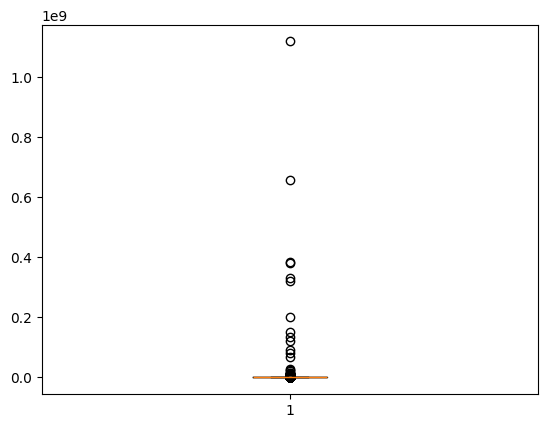

In [52]:
plt.boxplot(rel_mean_3)

In [29]:
#test set


x_test = torch.load('../../data/data_f/100_f_x.pt').clone()

test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

(32, 32)


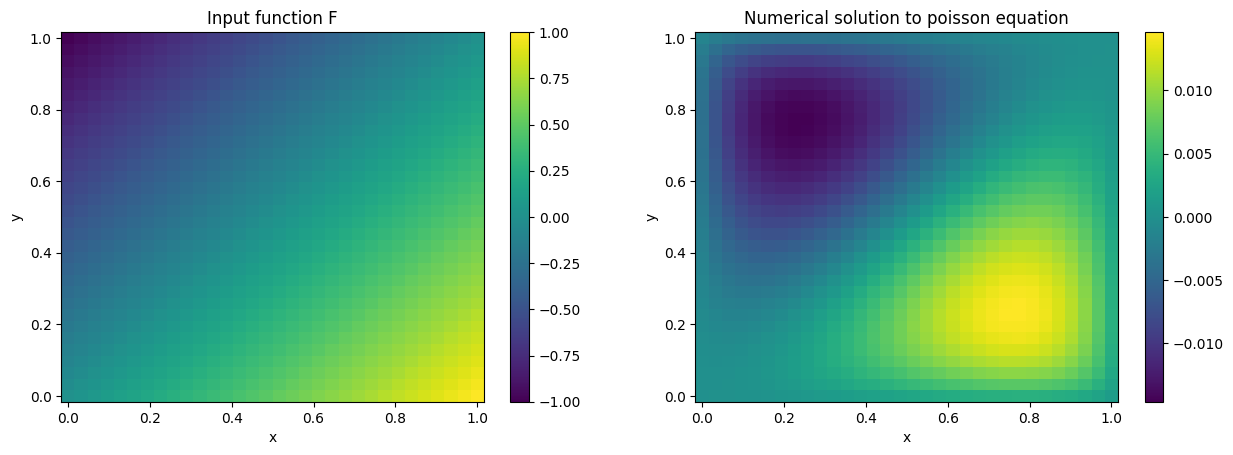

torch.Size([1, 1, 32, 32])


In [25]:
#the function
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
print(F.shape)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X-Y
#F = X**2 + Y**2
#for i in range(1,200):
    #F+= np.random.normal(0,10) *np.sin(i*X) * np.sin(i*Y) / np.sqrt((2*i**2)*np.pi**2)
#F = (X-0.5) * (Y-0.5)

#F = np.abs(X -0.25) * np.abs(Y-0.25) * np.abs(X +0.25) * np.abs(Y+0.25)


F*=1

#redefine for numerical solver, which solves Lu = f, so have to redefine
def solver(F, neumann,N):
    F_num = -F
    # Initialize the sparse matrix A
    main_diagonal = np.ones(N**2) * -4 / h**2
    offset_diagonals = np.ones(N**2 - 1) / h**2
    offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
    far_diagonals = np.ones(N**2 - N) / h**2

    # Create the sparse matrix A using diags
    A = sp.diags(
        [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
        [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')
    if neumann:

        for i in range(N):
            if i == 0 or i == N-1:
                A[i,:] = A[-(i+1),:] = 0
                A[i,i] = A[-(i+1),-(i+1)] = 1/h
            if i % N == 0 or (i+1) % N == 0:
                A[i,:] = 0
                A[i,i] = 1/h

    F_num = F_num.ravel()

    if neumann:
        F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

    # Solve the linear system
    u = scipy.sparse.linalg.spsolve(A, F_num)
    U = u.reshape((N, N))
    return U

U = solver(F,neumann,N)


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [26]:


def evaluator(model_list,sample):

    for i in range(M): model_list[i].eval().to(device) 

    sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
    sample_scaled = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample_scaled).to(device)

    out = [model_list[i](sample_scaled).to(device) for i in range(M)]
    #return to original scale
    out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

    mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
    var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)
    return mu_unseen, var_unseen



/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_14748/655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the spike: 0.00019183228141628206


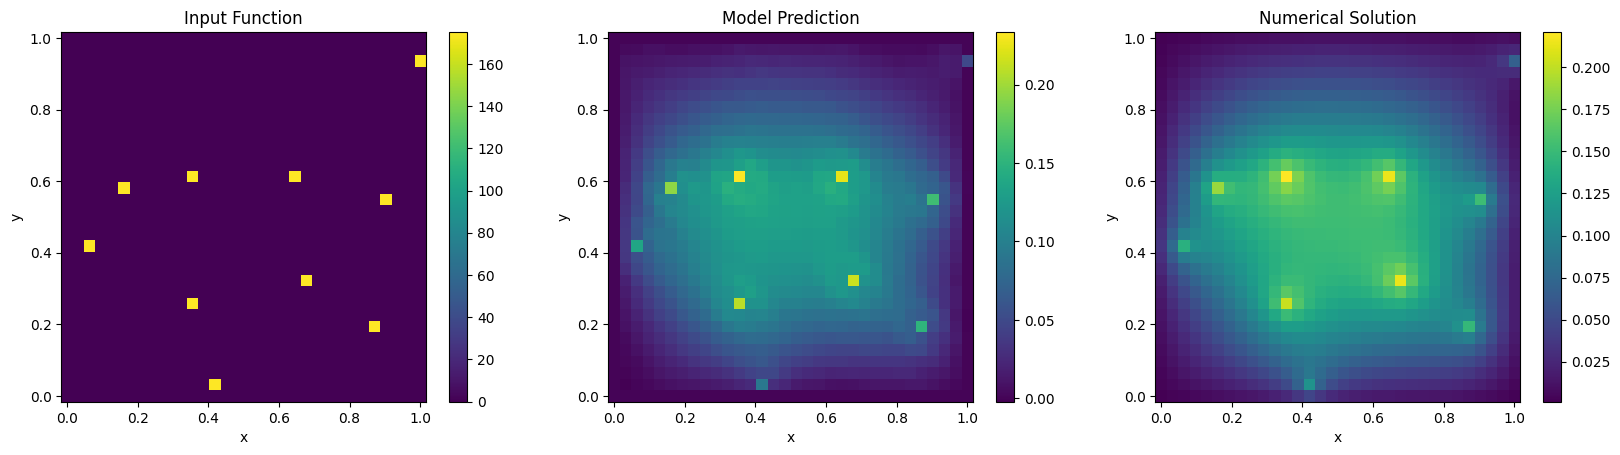

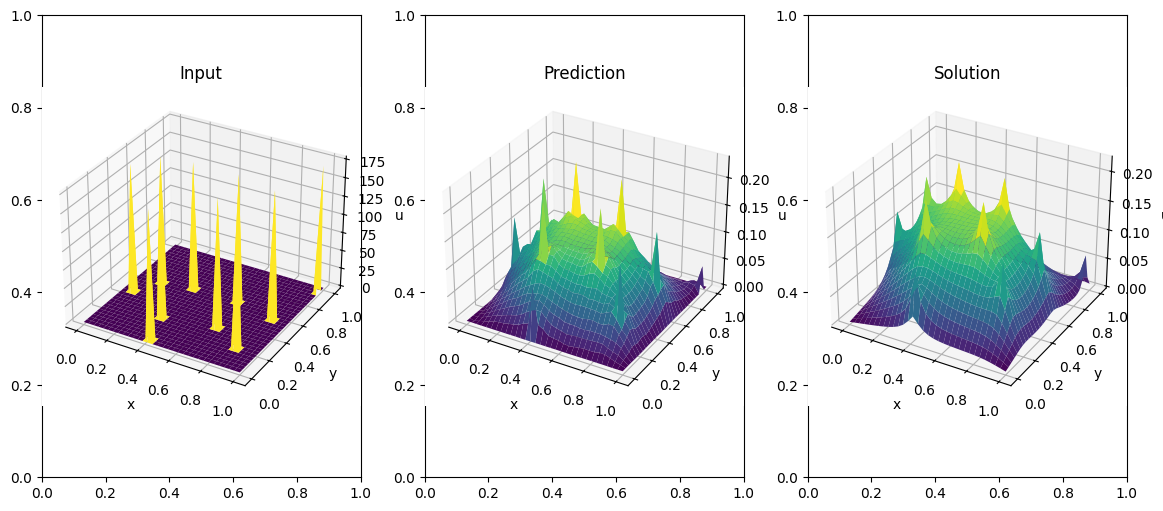

In [28]:
from plotting.results_plotter import plotter
from plotting.results_plotter_3D import plotter_3D

#make a random spike
sample = torch.zeros((32,32))
idx = np.random.randint(0,32**2,10)
sample[idx//32,idx%32] = 175


U = solver(sample,neumann,N)
U = torch.tensor(U).clone().to(device)

mu_spike, var_spike = evaluator(model_list,sample)
print(f"Max variance for the spike: {torch.max(var_spike).item()}")
plotter(sample,mu_spike[0,0,:,:],U,X,Y)
plotter_3D(sample,mu_spike[0,0,:,:],U,X,Y)



/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6000/655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the function: 0.029099460691213608
Loss: 0.19472324159882462


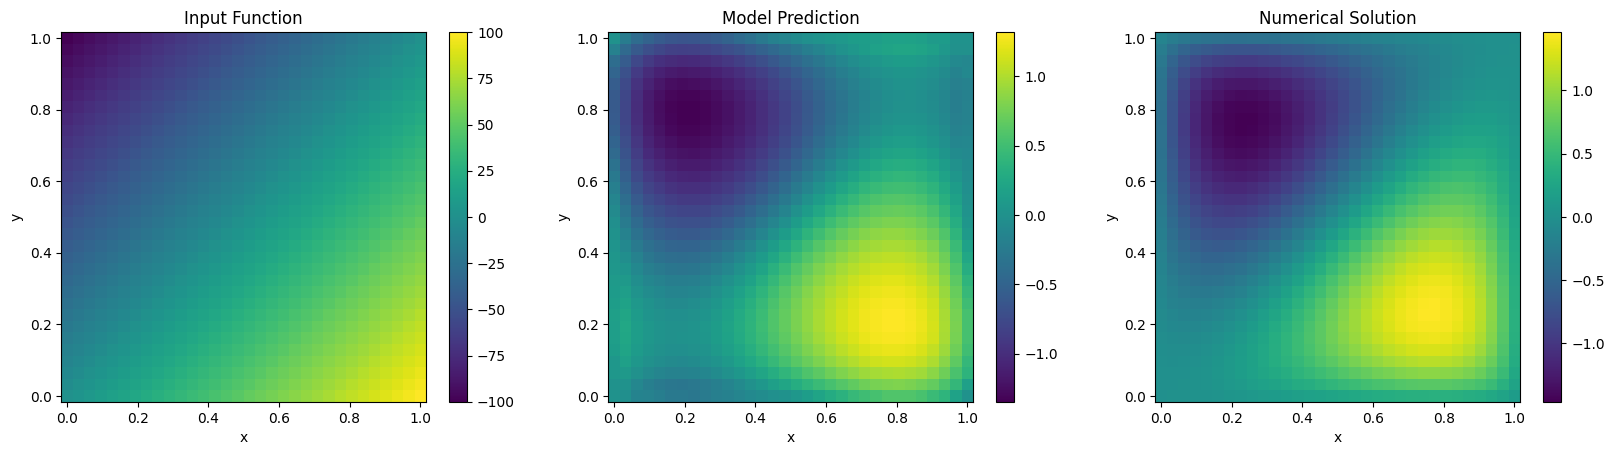

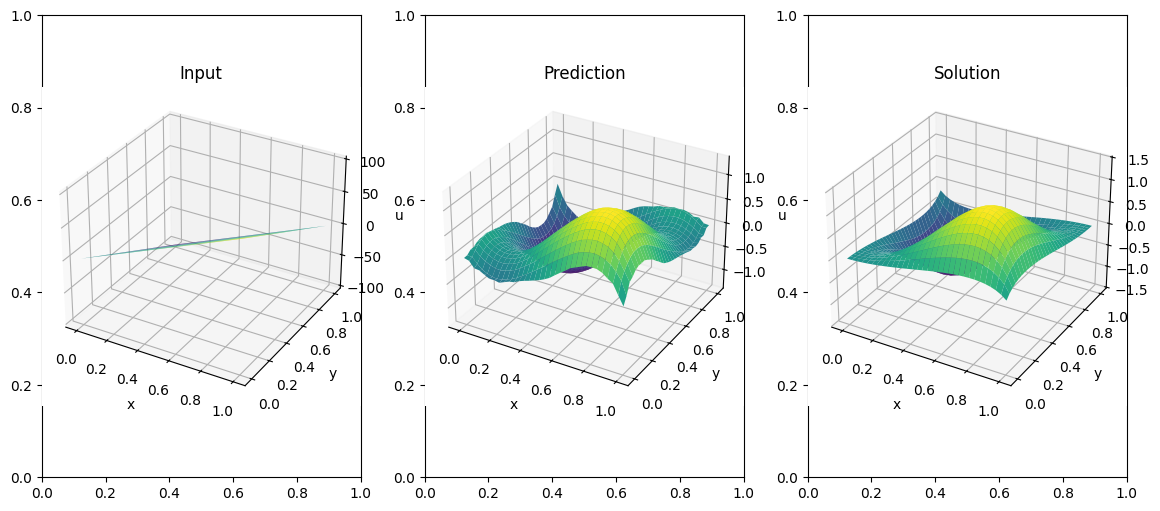

In [27]:
F = X-Y
F = torch.tensor(F)[None,None,:]
F*=100
U = solver(F,neumann,N)
U = torch.tensor(U).clone().to(device)

mu_F, var_F = evaluator(model_list,F)
print(f"Max variance for the function: {torch.max(var_F).item()}")
print(f"Loss: {train_loss(mu_F,U).item()}")
plotter(F[0,0,:,:],mu_F[0,0,:,:],U,X,Y)
plotter_3D(F[0,0,:,:],mu_F[0,0,:,:],U,X,Y)

/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_14748/655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the test: 0.00871722586452961
Loss: 0.18964769136051549


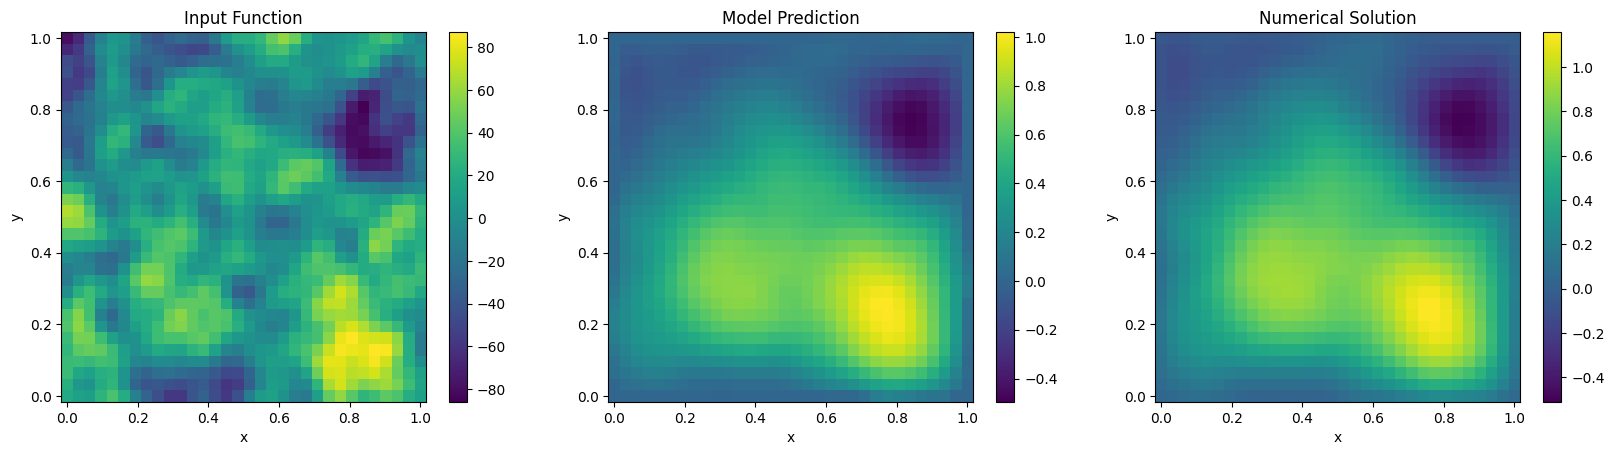

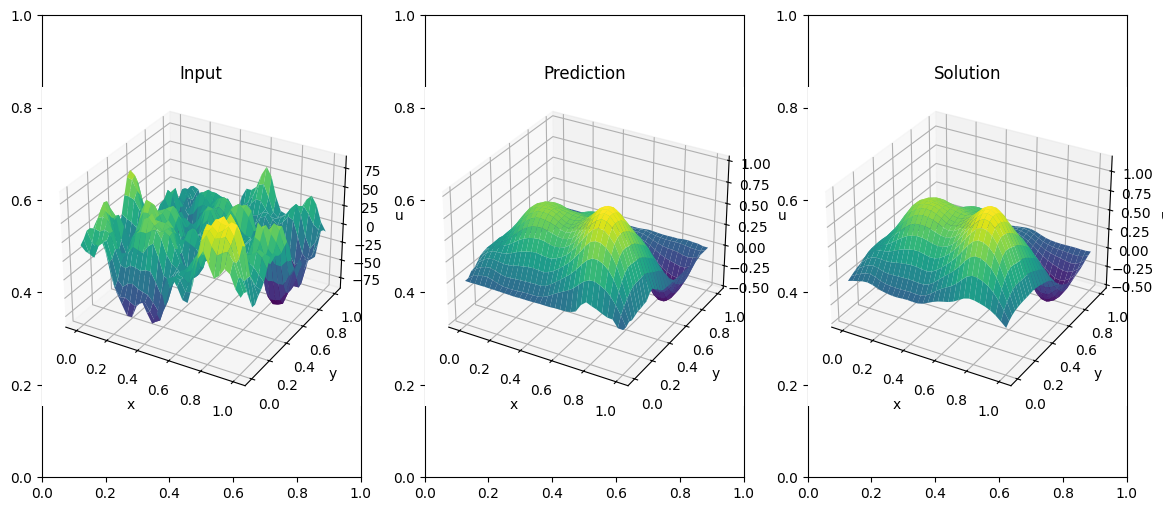

In [48]:
#test set element
i = np.random.randint(0,100)
j = np.random.randint(0,100)

#for the purposes of testing, we reimport the test loader so it is not transformed

sample = test_loader.dataset[i][0].unsqueeze(0).to(device) * 200
U = solver(sample,neumann,N)
U = torch.tensor(U).clone().to(device)

mu_test, var_test = evaluator(model_list,sample)

print(f"Max variance for the test: {torch.max(var_test).item()}")
print(f"Loss: {train_loss(mu_test.cpu(),U.cpu()).item()}")
plotter(sample[0,0,:,:],mu_test[0,0,:,:],U,X,Y)
plotter_3D(sample[0,0,:,:],mu_test[0,0,:,:],U,X,Y)        

In [33]:
(var_F<var_test ).sum()/torch.numel(var_test)*100

tensor(0.)

/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6000/655792342.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


Max variance for the rotation: 2.1142386685824022e-05
Loss: 0.006927590351551771


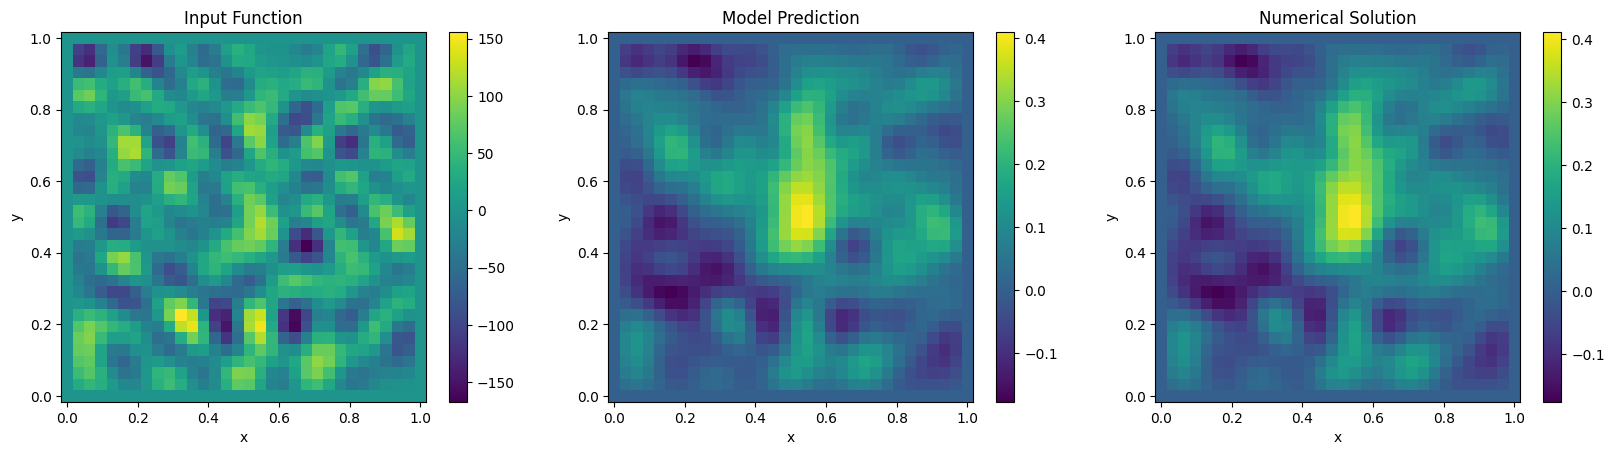

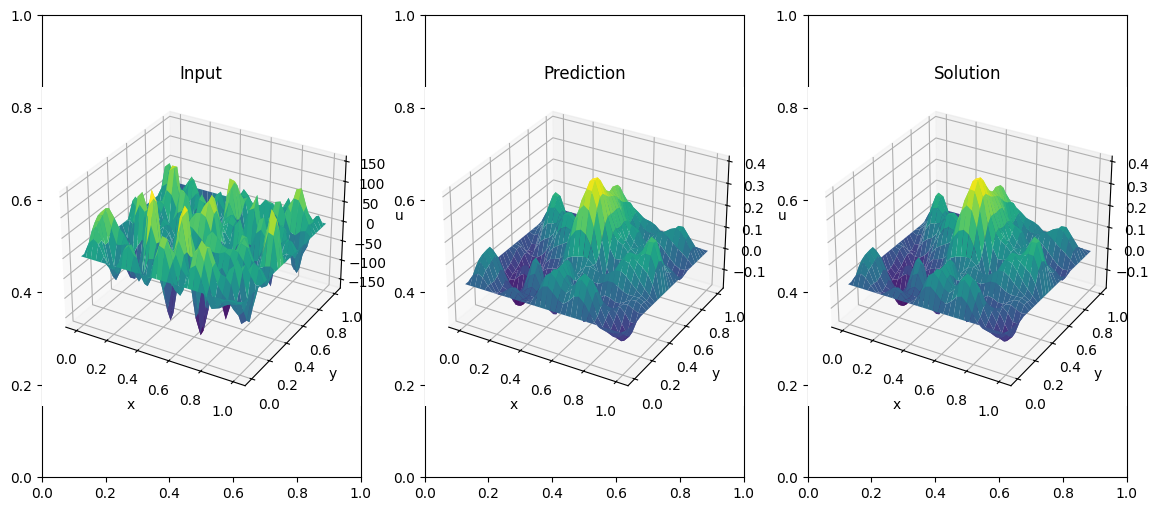

In [32]:
sample = torch.rot90(sample,1,[2,3])


mu_test_rot, var_test_rot = evaluator(model_list,sample)

solution = torch.rot90(solution,1,[2,3])

print(f"Max variance for the rotation: {torch.max(var_test_rot).item()}")
print(f"Loss: {train_loss(mu_test_rot.cpu(),solution.cpu()).item()}")
plotter(sample[0,0,:,:],mu_test_rot[0,0,:,:],solution[0,0,:,:],X,Y) 
plotter_3D(sample[0,0,:,:],mu_test_rot[0,0,:,:],solution[0,0,:,:],X,Y)        

In [34]:
(var_test_rot<var_test ).sum()/torch.numel(var_test)*100


tensor(45.1172)